In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout
from scenarios.price_scenario import PriceScenarioGenerator

In [2]:
# === Load training data: full November 2024 ===
df_train, price_train, timestamps_train = load_price_data(
    csv_path="../data/raw/dayahead_2024_11.csv",
    resolution="15min",
)

# === Load evaluation data: first week of November 2025 ===
df_eval, price_eval, timestamps_eval = load_price_data(
    csv_path="../data/raw/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", timestamps_eval[0], "to", timestamps_eval[-1])

672 time steps in a week (should be 672)
Week from 2025-11-01 00:00:00+01:00 to 2025-11-07 23:45:00+01:00


In [3]:
forecast_horizon_steps = int(round(3.0 / 0.25))  # 3h forecast, 15 min steps → 12 steps

price_scenario_gen = PriceScenarioGenerator(
    horizon_steps=forecast_horizon_steps,
    sigma0=0.01,
    sigmaH=0.06,
    schedule="sqrt",
    base_seed=1234,
)


In [4]:
def make_eval_env():
    return BatteryEnv(
        price_series=price_eval,
        demand_series=None,
        timestamps=timestamps_eval,
        dt_hours=0.25,
        capacity_kWh=50.0,
        p_max_kW=10.0,
        use_discrete_actions=True,
        use_price_forecast=True,
        forecast_horizon_hours=3.0,
        episode_days=7.0,
        random_start=False,
        random_seed=123,
        scenario_gen=price_scenario_gen,
        scenario_id=0,
    )

def make_train_env(seed=None):
    env_raw = BatteryEnv(
        price_series=price_train,
        demand_series=None,
        timestamps=timestamps_train,
        dt_hours=0.25,
        capacity_kWh=50.0,
        p_max_kW=10.0,
        use_discrete_actions=True,
        use_price_forecast=True,
        forecast_horizon_hours=3.0,
        episode_days=7.0,
        random_start=True,
        random_seed=seed,
        scenario_gen=price_scenario_gen,
        scenario_id=0,
    )
    return Monitor(env_raw)

In [5]:
checkpoints = [1_000, 5_000, 10_000 ,20_000, 40_000, 60_000]

N_RUNS = 10
rows = []

for run_id in range(N_RUNS):
    train_env = make_train_env(seed=None)


    model = DQN(
        "MlpPolicy",
        train_env,
        learning_rate=1e-3,
        buffer_size=50_000,
        learning_starts=1_000,
        batch_size=64,
        gamma=0.99,
        train_freq=4,
        target_update_interval=1_000,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.05,
        exploration_fraction=0.3,
        verbose=0,
    )

    prev_steps = 0

    for steps in checkpoints:
        model.learn(
            total_timesteps=steps - prev_steps,
            reset_num_timesteps=False,
            progress_bar=False,
        )
        prev_steps = steps

        eval_env = make_eval_env()
        results = evaluate_rollout(model=model, env=eval_env)

        total_reward = float(np.sum(results["reward"]))
        mean_reward_step = float(np.mean(results["reward"]))
        total_revenue = float(np.sum(results["revenue"]))
        total_deg = float(np.sum(results["deg_cost"]))
        total_penalty = float(np.sum(results["penalty"]))

        rows.append({
            "run_id": run_id,
            "train_steps": steps,
            "eval_total_reward": total_reward,
            "eval_total_revenue": total_revenue,
            "eval_total_deg_cost": total_deg,
            "eval_total_penalty": total_penalty,
        })

    train_env.close()

df = pd.DataFrame(rows)
df


Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished early at step 671
Episode finished ear

,run_id,train_steps,eval_total_reward,eval_total_revenue,eval_total_deg_cost,eval_total_penalty
0,0,1000,-662.399741,0.631335,0.031076,-663.0
1,0,5000,-54.552900,-0.776074,0.776826,-53.0
2,0,10000,-0.787156,0.382145,0.169301,-1.0
3,0,20000,3.332580,4.973961,0.641382,-1.0
4,0,40000,-7.591313,4.326681,1.917994,-10.0
5,0,60000,-246.120816,8.766211,0.887026,-254.0
6,1,1000,-336.364359,-0.027014,1.337345,-335.0
7,1,5000,0.627987,0.658462,0.030475,0.0
8,1,10000,-0.537591,-0.103765,0.433826,0.0
9,1,20000,-1.404498,-0.636258,0.768241,0.0


In [6]:
agg = df.groupby("train_steps").agg(
    mean_eval_total_reward=("eval_total_reward", "mean"),
    std_eval_total_reward=("eval_total_reward", "std"),
    mean_eval_total_revenue=("eval_total_revenue", "mean"),
    std_eval_total_revenue=("eval_total_revenue", "std"),
).reset_index()

agg


,train_steps,mean_eval_total_reward,std_eval_total_reward,mean_eval_total_revenue,std_eval_total_revenue
0,1000,-531.574867,215.390294,-0.371898,1.047635
1,5000,-229.208189,216.463030,0.179149,1.012219
2,10000,-62.450720,132.931077,0.116288,0.970784
3,20000,-8.479194,18.635367,3.159905,3.372499
4,40000,-20.967999,46.989060,5.024823,3.772105
5,60000,-100.907171,100.701943,6.582782,4.404968


In [7]:
best_row = agg.loc[agg["mean_eval_total_reward"].idxmax()]
best_row


train_steps                20000.000000
mean_eval_total_reward        -8.479194
std_eval_total_reward         18.635367
mean_eval_total_revenue        3.159905
std_eval_total_revenue         3.372499
Name: 3, dtype: float64

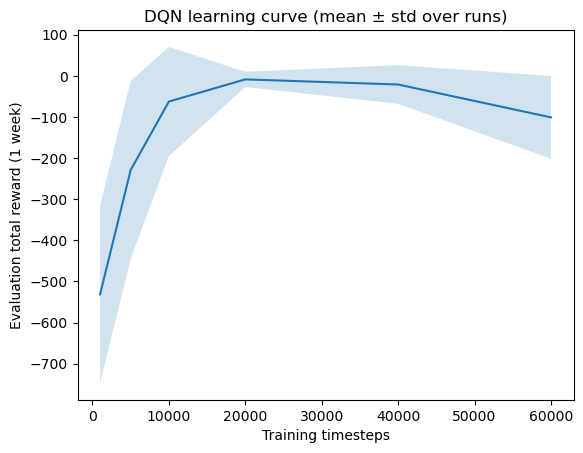

In [8]:
plt.figure()
plt.plot(agg["train_steps"], agg["mean_eval_total_reward"])
plt.fill_between(
    agg["train_steps"],
    agg["mean_eval_total_reward"] - agg["std_eval_total_reward"],
    agg["mean_eval_total_reward"] + agg["std_eval_total_reward"],
    alpha=0.2,
)
plt.xlabel("Training timesteps")
plt.ylabel("Evaluation total reward (1 week)")
plt.title("DQN learning curve (mean ± std over runs)")
plt.show()
